# Central Model Evaluation Part 2

The central model is evaluated for the cincinnati dataset.
Especially the prediction results and patterns learned by the deep learning algorithm are analyzed.
In Part 1, only one selected vehicle was used for training.
This time, the network is trained on the  whole dataset.

## Imports

In [1]:
import collections
import functools
import os
import time

import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow import feature_column
from tensorflow.keras import layers
from tqdm import tqdm
import import_ipynb

In [2]:
from model_helper import ModelHelper

importing Jupyter notebook from model_helper.ipynb


## DataSet

This time, the full dataset is used.

In [3]:
df = pd.read_csv("./cincinnati/cincinatti_zones.csv")
df.head(10)

,location_id,vehicle_id,is_weekend,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
0,0,317,False,0.722314,-0.691566,0.743145,0.669131,0.5,0.866025,0.0,1.0
1,1,483,False,0.605120,-0.796134,0.743145,0.669131,0.5,0.866025,0.0,1.0
2,0,130,False,-0.313233,-0.949676,0.743145,0.669131,0.5,0.866025,0.0,1.0
3,2,276,False,0.156363,-0.987700,0.743145,0.669131,0.5,0.866025,0.0,1.0
4,3,317,False,-0.350548,-0.936545,0.743145,0.669131,0.5,0.866025,0.0,1.0
5,0,197,False,0.587668,-0.809102,0.743145,0.669131,0.5,0.866025,0.0,1.0
6,4,380,False,0.438633,0.898666,0.743145,0.669131,0.5,0.866025,0.0,1.0
7,5,318,False,-0.300706,-0.953717,0.743145,0.669131,0.5,0.866025,0.0,1.0
8,4,72,False,0.795914,-0.605410,0.743145,0.669131,0.5,0.866025,0.0,1.0
9,3,301,False,-0.043837,-0.999039,0.743145,0.669131,0.5,0.866025,0.0,1.0


In [4]:
# the number of different locations defines the vocabulary size
locations = df.location_id
vocab_size = locations.nunique()

print('vocabulary size:', vocab_size)

vocabulary size: 100


Init the ModelHelper and set all needed parameters such as the different column_names and the vocab_size.

In [5]:
mh = ModelHelper(df, 17)

In [6]:
mh.set_target_column_name('location_id')
mh.set_vocab_size(vocab_size)

numerical_column_names = ['clock_sin', 'clock_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'week_day_sin', 'week_day_cos']
column_names = ['location_id'] + numerical_column_names
mh.set_column_names(column_names)
mh.set_numerical_column_names(numerical_column_names)

mh.set_client_column_name('vehicle_id')
mh.set_client_column_ids()

In [7]:
count = df.vehicle_id.value_counts()

idx = count.loc[count.index[:100]].index # count >= 100
df = df.loc[df.vehicle_id.isin(idx)]

An array is created containing all visited locations for every user.
The original data is sorted by time (ascending).
Thus, the array contains a sequence of visited locations by user.

In [8]:
mh.create_users_locations_from_df()

100%|██████████| 314/314 [00:05<00:00, 57.70it/s]


[          location_id  vehicle_id  is_weekend  clock_sin  clock_cos   day_sin  \
 0                   0         317       False   0.722314  -0.691566  0.743145   
 4                   3         317       False  -0.350548  -0.936545  0.743145   
 13                  0         317       False   0.426437  -0.904517  0.743145   
 140                16         317       False  -0.473512  -0.880787  0.743145   
 248                 0         317       False   0.580525  -0.814242  0.743145   
 ...               ...         ...         ...        ...        ...       ...   
 14488858            2         317       False   0.833806  -0.552058 -0.587785   
 14489062            3         317       False   0.138885  -0.990309 -0.866025   
 14489282            2         317       False  -0.662783  -0.748811  0.587785   
 14489315           42         317       False   0.583955  -0.811786  0.743145   
 14489358            0         317       False   0.662620  -0.748956 -0.207912   
 
            da

It is necessary to first split the data in train, valid and test for each user.
Then, these are merged together again later on.
This is done to ensure that the sequences are kept together and not split randomly for the users.

In [9]:
mh.concat_split_users_locations()

In [10]:
print(len(mh.df_train), 'train examples')
print(len(mh.df_val), 'validation examples')
print(len(mh.df_test), 'test examples')

9280354 train examples
2320247 validation examples
2900303 test examples


Split the data and create the batch datasets.

In [11]:
#mh.split_data_sliding()
mh.split_data()
print(len(mh.list_test))
mh.list_test[0]

170607


,location_id,is_weekend,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
12440612,25,False,0.418528,-0.908204,0.587785,-0.809017,-0.5,-0.866025,0.0,1.0
12440631,0,False,0.927129,-0.374741,0.587785,-0.809017,-0.5,-0.866025,0.0,1.0
12440723,25,False,0.529858,-0.848087,0.587785,-0.809017,-0.5,-0.866025,0.0,1.0
12440784,3,False,-0.143637,-0.989631,0.587785,-0.809017,-0.5,-0.866025,0.0,1.0
12440959,25,False,0.296403,-0.955063,0.587785,-0.809017,-0.5,-0.866025,0.0,1.0
12441062,25,False,0.406670,-0.913575,0.587785,-0.809017,-0.5,-0.866025,0.0,1.0
12441086,0,False,0.608704,-0.793398,0.587785,-0.809017,-0.5,-0.866025,0.0,1.0
12441218,0,False,0.190452,-0.981696,0.587785,-0.809017,-0.5,-0.866025,0.0,1.0
12441299,25,False,0.457615,-0.889150,0.587785,-0.809017,-0.5,-0.866025,0.0,1.0
12441389,0,False,0.544334,-0.838869,0.587785,-0.809017,-0.5,-0.866025,0.0,1.0


In [12]:
mh.set_batch_size(16)
mh.create_and_batch_datasets(multi_target=False)

In [13]:
# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units1 = 256
rnn_units2 = 128

# Create a model
def create_keras_model():
  N = mh.total_window_length
  batch_size = mh.batch_size
  number_of_places = mh.vocab_size

  # Shortcut to the layers package
  l = tf.keras.layers

  # List of numeric feature columns to pass to the DenseLayer
  numeric_feature_columns = []

  # Handling numerical columns
  for header in numerical_column_names:
	# Append all the numerical columns defined into the list
    numeric_feature_columns.append(feature_column.numeric_column(header, shape=N-1))

  feature_inputs={}
  for c_name in numerical_column_names:
    feature_inputs[c_name] = tf.keras.Input((N-1,), batch_size=batch_size, name=c_name)

  # We cannot use an array of features as always because we have sequences
  # We have to do one by one in order to match the shape
  num_features = []
  for c_name in numerical_column_names:
    f =  feature_column.numeric_column(c_name, shape=(N-1))
    feature = l.DenseFeatures(f)(feature_inputs)
    feature = tf.expand_dims(feature, -1)
    num_features.append(feature)

  # Declare the dictionary for the locations sequence as before
  sequence_input = {
      'location_id': tf.keras.Input((N-1,), batch_size=batch_size, dtype=tf.dtypes.int32, name='location_id') # add batch_size=batch_size in case of stateful GRU
  }

  # Handling the categorical feature sequence using one-hot
  location_one_hot = feature_column.sequence_categorical_column_with_vocabulary_list(
      'location_id', [i for i in range(number_of_places)])

  # one-hot encoding
  location_feature = feature_column.embedding_column(location_one_hot, embedding_dim)

  # With an input sequence we can't use the DenseFeature layer, we need to use the SequenceFeatures
  sequence_features, sequence_length = tf.keras.experimental.SequenceFeatures(location_feature)(sequence_input)


  input_sequence = l.Concatenate(axis=2)([sequence_features] + num_features)

  # Rnn
  recurrent = l.GRU(rnn_units1,
                    batch_size=batch_size, #in case of stateful
                    return_sequences=True,
                    stateful=True,
                    recurrent_initializer='glorot_uniform')(input_sequence)

  recurrent_2 = l.GRU(rnn_units2,
                      batch_size=batch_size, #in case of stateful
                      stateful=True,
                      recurrent_initializer='glorot_uniform')(recurrent)


  # Softmax output layer
  # Last layer with an output for each places
  output = layers.Dense(number_of_places, activation='softmax')(recurrent_2)


  # To return the Model, we need to define its inputs and outputs
  # In out case, we need to list all the input layers we have defined
  inputs = list(feature_inputs.values()) + list(sequence_input.values())

  # Return the Model
  return tf.keras.Model(inputs=inputs, outputs=output)

In [14]:
# Get the model and compile it
mh.assign_model(create_keras_model())
mh.compile_model()

In [15]:
mh.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clock_cos (InputLayer)          [(16, 16)]           0                                            
__________________________________________________________________________________________________
clock_sin (InputLayer)          [(16, 16)]           0                                            
__________________________________________________________________________________________________
day_cos (InputLayer)            [(16, 16)]           0                                            
__________________________________________________________________________________________________
day_sin (InputLayer)            [(16, 16)]           0                                            
_______________________________________________________________________________________

In [16]:
mh.set_num_epochs(5)
mh.fit_model()

Epoch 1/5
34118/34118 [==============================] - 368s 11ms/step - loss: 1.9084 - sparse_categorical_accuracy: 0.4005 - val_loss: 2.0603 - val_sparse_categorical_accuracy: 0.3702
Epoch 2/5
34118/34118 [==============================] - 371s 11ms/step - loss: 1.8693 - sparse_categorical_accuracy: 0.4043 - val_loss: 2.0330 - val_sparse_categorical_accuracy: 0.3763
Epoch 3/5
34118/34118 [==============================] - 381s 11ms/step - loss: 1.8708 - sparse_categorical_accuracy: 0.4033 - val_loss: 2.0640 - val_sparse_categorical_accuracy: 0.3625
Epoch 4/5
34118/34118 [==============================] - 382s 11ms/step - loss: 1.8725 - sparse_categorical_accuracy: 0.4030 - val_loss: 2.0265 - val_sparse_categorical_accuracy: 0.3755
Epoch 5/5
34118/34118 [==============================] - 377s 11ms/step - loss: 1.8736 - sparse_categorical_accuracy: 0.4028 - val_loss: 2.0321 - val_sparse_categorical_accuracy: 0.3711
Epoch 00005: early stopping


In [17]:
mh.evaluate_model()

10662/10662 [==============================] - 37s 3ms/step - loss: 2.3478 - sparse_categorical_accuracy: 0.3016


## Evaluation of the model prediction

The model achieved an even better performance when using all the vehicles together.
This might give the model more time to learn patterns or a similar phenomenon as with the 4square data could be observed.
Whether the increase came from a better understanding of driving patterns or not, is to be figured out in the following.

Manually predict the logits for the test dataset.

In [18]:
def print_info(T):
    print('Element #0:', T[0])
    print('Shape:', T.shape)

In [19]:
logits = mh.model.predict(mh.test_dataset)
print_info(logits)

Element #0: [4.3907800e-01 3.1982330e-03 1.6925035e-03 3.6770485e-02 4.6975747e-02
 9.6381968e-03 5.5058696e-03 3.7892747e-03 1.6983104e-03 8.5583990e-03
 5.4115159e-03 5.1448788e-02 1.2622395e-03 1.3228840e-01 2.8772296e-03
 7.2852247e-03 1.0755109e-02 6.0655605e-02 8.6341716e-02 1.1223454e-03
 4.0465789e-03 4.8777091e-04 1.7552837e-03 1.6398996e-02 4.5843534e-03
 4.0562268e-02 1.0354811e-04 3.1638509e-04 6.2367809e-04 2.2641234e-03
 6.7220647e-03 6.2094541e-04 1.9480036e-04 1.1705379e-03 4.5061792e-05
 5.8129863e-06 1.0174538e-04 5.9733994e-04 1.0909313e-05 8.1742753e-04
 4.4022070e-04 3.7861030e-04 4.2815147e-05 6.4428845e-05 4.0013090e-11
 5.8486080e-04 2.8312636e-05 3.6251267e-06 8.3649509e-05 4.3697678e-04
 2.3505611e-06 6.3357811e-06 3.9796309e-06 1.0505380e-05 3.0404875e-05
 4.3371401e-10 9.7338514e-08 5.8717706e-05 6.1660544e-06 1.8765802e-07
 2.3144094e-05 8.5609429e-07 6.2496710e-08 2.5618908e-07 1.1454524e-07
 2.8907484e-08 4.5781290e-10 3.2869128e-08 3.6609845e-06 1.993976

In [20]:
predictions = tf.nn.softmax(logits, axis=1)
print_info(predictions)

Element #0: tf.Tensor(
[0.01533921 0.0099198  0.00990487 0.01025848 0.01036371 0.00998388
 0.00994271 0.00992566 0.00990493 0.00997311 0.00994177 0.01041017
 0.00990061 0.01128667 0.00991661 0.00996042 0.00999504 0.01050645
 0.01077982 0.00989922 0.00992821 0.00989294 0.00990549 0.01005161
 0.00993355 0.01029745 0.00988914 0.00989125 0.00989429 0.00991053
 0.00995481 0.00989426 0.00989005 0.0098997  0.00988857 0.00988818
 0.00988913 0.00989403 0.00988823 0.00989621 0.00989247 0.00989186
 0.00988854 0.00988876 0.00988812 0.0098939  0.0098884  0.00988816
 0.00988895 0.00989244 0.00988814 0.00988818 0.00988816 0.00988822
 0.00988842 0.00988812 0.00988812 0.0098887  0.00988818 0.00988812
 0.00988835 0.00988813 0.00988812 0.00988812 0.00988812 0.00988812
 0.00988812 0.00988812 0.00988816 0.00988812 0.00988812 0.00988812
 0.00988812 0.00988812 0.00988814 0.00988812 0.00988814 0.00988812
 0.00988812 0.00988812 0.00988812 0.00988812 0.00988812 0.00988812
 0.00988816 0.00988812 0.00988812 0.009

In [21]:
predicted_classes = np.argmax(predictions, 1)
print_info(predicted_classes)

Element #0: 0
Shape: (170592,)


Obtain the actual values of the test_dataset by unbatching and create an array containing these.
Then compute the difference in predictions and actual values.

In [22]:
actual_values = []
X_loc = []
for x, y in mh.test_dataset.unbatch():
    actual_values.append(y.numpy())
    X_loc.append(x['location_id'].numpy())

actual_values = np.array(actual_values)
X_loc = np.array(X_loc)

diff = actual_values - predicted_classes
print(diff.shape)
unique, counts = np.unique(diff, return_counts=True)

print('actual_values')
print_info(actual_values)
print('predicted_classes')
print_info(predicted_classes)
print('diff')
print_info(diff)

(170592,)
actual_values
Element #0: 3
Shape: (170592,)
predicted_classes
Element #0: 0
Shape: (170592,)
diff
Element #0: 3
Shape: (170592,)


Sanity check the results, compute the accuracy (should be roughly the same) by comparing the wrong and correct  predictions

In [23]:
wrong = np.count_nonzero(diff)
size = diff.shape[0]
correct =  size - wrong
acc = correct / size
print('# correct Predictions : ', correct)
print('# wrong Predictions : ', wrong)
print('accuracy: ', acc)

# correct Predictions :  51453
# wrong Predictions :  119139
accuracy:  0.3016143781654474


Show the predicted classes and their prediction counts.

In [24]:
res = pd.DataFrame(predicted_classes)
unique, counts = np.unique(res, return_counts=True)
print(unique)
print(counts)

[ 0  1  2  3  4  6  7  8  9 10 11 12 13 15 17 18 19 20 21 22 23 24 25 27
 29 31 36 46 57 61 68]
[26418   470   142  3962 54530   338  1965 19744   853  1398  1025    85
 44106  3554    34  6159     1   272  1942    51    53  1753     7   215
    33   592     6   877     5     1     1]


The model learned to predict mostly the dominant classes.
This could be seen for many other models that were trained.

In [25]:
res = pd.DataFrame(actual_values)
unique, counts = np.unique(res, return_counts=True)
print(unique)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 72
 73 74 75 76 77 82 85 86 87 88 89 90 93 94 95 96 97 99]
[12852  7531  4793  5631 38068   887  3309  8150 11608  4533  3139  4881
  4260 21700   440  6593   991  1373  6403   633  1923  1224  5484   465
  5821   741    14  1208    60   431   190   732   118   609    32   127
  1166    40    12   191   412   101   432    57     5   344   164    16
    22     5     4    10     4    75    34     2    15    71    36     1
    17    32    15   129    32    17    19     5    17    14     7     9
     1     6     4    11     4    12     5     6     4     9    23     3
     3     1     2     3     2     7]


Next, take a look at some exemplary predictions:

In [26]:
for i in range(0,20):
    print('Prediction #', i)
    print('Actual value: ', actual_values[i])
    print('Predicted value: ', predicted_classes[i])

Prediction # 0
Actual value:  3
Predicted value:  0
Prediction # 1
Actual value:  4
Predicted value:  0
Prediction # 2
Actual value:  25
Predicted value:  0
Prediction # 3
Actual value:  0
Predicted value:  0
Prediction # 4
Actual value:  11
Predicted value:  0
Prediction # 5
Actual value:  0
Predicted value:  0
Prediction # 6
Actual value:  25
Predicted value:  0
Prediction # 7
Actual value:  3
Predicted value:  0
Prediction # 8
Actual value:  0
Predicted value:  0
Prediction # 9
Actual value:  3
Predicted value:  0
Prediction # 10
Actual value:  0
Predicted value:  0
Prediction # 11
Actual value:  0
Predicted value:  0
Prediction # 12
Actual value:  25
Predicted value:  0
Prediction # 13
Actual value:  9
Predicted value:  0
Prediction # 14
Actual value:  16
Predicted value:  0
Prediction # 15
Actual value:  2
Predicted value:  18
Prediction # 16
Actual value:  2
Predicted value:  18
Prediction # 17
Actual value:  14
Predicted value:  0
Prediction # 18
Actual value:  31
Predicted valu

Create a matrix for the x and y values by concatenation.
The rows contain all locations used for the prediction.

In [27]:
Y = np.expand_dims(actual_values, -1)
print('X_loc.shape ', X_loc.shape)
print('Y.shape ', Y.shape)
X_Y = np.concatenate((X_loc, Y), axis=1)
print('X_Y.shape: ', X_Y.shape)
X_Y[:10]

X_loc.shape  (170592, 16)
Y.shape  (170592, 1)
X_Y.shape:  (170592, 17)


array([[25,  0, 25,  3, 25, 25,  0,  0, 25,  0, 18,  0,  3, 25,  0,  0,
         3],
       [ 0,  0,  0,  9, 25, 25,  0,  3,  0,  0,  0, 25, 11, 25,  0,  0,
         4],
       [ 0, 25, 16,  0, 25, 25, 25, 25, 25, 13,  0,  0, 25, 25,  0,  0,
        25],
       [ 0,  0,  5,  0,  0, 25, 18,  0,  0,  3,  0,  3,  0,  0,  0, 25,
         0],
       [25,  0,  0,  3, 25, 25,  3,  0,  0,  0, 11, 25,  0, 25,  0,  0,
        11],
       [ 0,  0,  0,  0,  0,  4,  0,  3, 25,  0,  0,  0,  0,  0,  0,  0,
         0],
       [13,  0,  0, 25,  0,  0, 25,  0,  0,  0,  4,  9,  0,  0, 25,  0,
        25],
       [25, 25, 16,  0,  0, 25, 25,  9,  4,  0, 13,  3, 25,  3,  0,  0,
         3],
       [ 0,  0,  0,  0, 25,  0, 16,  5, 25, 25, 16,  3,  9,  3, 25,  0,
         0],
       [25,  0,  0, 11, 25, 25,  0,  0, 25,  0, 25,  0,  4,  4,  0, 25,
         3]], dtype=int64)

Create an array of the column names.

In [28]:
columns = []
for i in range(0,16):
    columns.append('loc_' + str(i))
columns.append('y_true')
columns

['loc_0',
 'loc_1',
 'loc_2',
 'loc_3',
 'loc_4',
 'loc_5',
 'loc_6',
 'loc_7',
 'loc_8',
 'loc_9',
 'loc_10',
 'loc_11',
 'loc_12',
 'loc_13',
 'loc_14',
 'loc_15',
 'y_true']

Assign the column names and create a pandas dataframe.

In [29]:
df = pd.DataFrame(X_Y, columns = columns)
df

,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,loc_11,loc_12,loc_13,loc_14,loc_15,y_true
0,25,0,25,3,25,25,0,0,25,0,18,0,3,25,0,0,3
1,0,0,0,9,25,25,0,3,0,0,0,25,11,25,0,0,4
2,0,25,16,0,25,25,25,25,25,13,0,0,25,25,0,0,25
3,0,0,5,0,0,25,18,0,0,3,0,3,0,0,0,25,0
4,25,0,0,3,25,25,3,0,0,0,11,25,0,25,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170587,4,18,4,4,18,15,15,24,18,4,15,15,4,15,18,15,15
170588,7,16,18,3,13,4,13,45,33,5,45,12,11,15,15,18,45
170589,4,12,15,3,3,11,15,5,18,7,7,7,15,4,11,15,15
170590,2,4,1,16,13,1,4,11,3,4,3,4,8,7,4,3,4


Add the predicted classes.

In [30]:
df['y_pred'] = predicted_classes
df

,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,loc_11,loc_12,loc_13,loc_14,loc_15,y_true,y_pred
0,25,0,25,3,25,25,0,0,25,0,18,0,3,25,0,0,3,0
1,0,0,0,9,25,25,0,3,0,0,0,25,11,25,0,0,4,0
2,0,25,16,0,25,25,25,25,25,13,0,0,25,25,0,0,25,0
3,0,0,5,0,0,25,18,0,0,3,0,3,0,0,0,25,0,0
4,25,0,0,3,25,25,3,0,0,0,11,25,0,25,0,0,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170587,4,18,4,4,18,15,15,24,18,4,15,15,4,15,18,15,15,15
170588,7,16,18,3,13,4,13,45,33,5,45,12,11,15,15,18,45,18
170589,4,12,15,3,3,11,15,5,18,7,7,7,15,4,11,15,15,15
170590,2,4,1,16,13,1,4,11,3,4,3,4,8,7,4,3,4,18


Add a column "correct" that displays whether the prediction was correct or not.

In [31]:
df['correct'] = df['y_true'] - df['y_pred']

def reduce01 (val):
    if val == 0:
        return True
    else:
        return False

df['correct'] = df['correct'].map(reduce01)
df

,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,loc_11,loc_12,loc_13,loc_14,loc_15,y_true,y_pred,correct
0,25,0,25,3,25,25,0,0,25,0,18,0,3,25,0,0,3,0,False
1,0,0,0,9,25,25,0,3,0,0,0,25,11,25,0,0,4,0,False
2,0,25,16,0,25,25,25,25,25,13,0,0,25,25,0,0,25,0,False
3,0,0,5,0,0,25,18,0,0,3,0,3,0,0,0,25,0,0,True
4,25,0,0,3,25,25,3,0,0,0,11,25,0,25,0,0,11,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170587,4,18,4,4,18,15,15,24,18,4,15,15,4,15,18,15,15,15,True
170588,7,16,18,3,13,4,13,45,33,5,45,12,11,15,15,18,45,18,False
170589,4,12,15,3,3,11,15,5,18,7,7,7,15,4,11,15,15,15,True
170590,2,4,1,16,13,1,4,11,3,4,3,4,8,7,4,3,4,18,False


Fill missing rows and columns in order to have a full matrix of NxN with N being the number of unique predictions.

In [32]:
def fill_missing(df, matrix, column_name):
    columns = set(df['y_pred'].values) | set(df[column_name].values)
    columns = list(columns)
    matrix = matrix.reindex(columns = columns)
    matrix = np.transpose(matrix)
    matrix = matrix.reindex(columns = columns)
    matrix = np.transpose(matrix)
    matrix[np.isnan(matrix)] = 0
    return matrix

First, check whether the network also predicts the last location as the next location in most cases.

In [33]:
matrix = df.groupby(['y_pred', 'loc_15']).size().unstack(fill_value=0, level=0)
matrix = fill_missing(df, matrix, 'loc_15')
matrix

y_pred,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,93,94,95,96,97,99
loc_15,,,,,,,,,,,,,,,,,,,,,
0,8142.0,0.0,0.0,7.0,1497.0,0.0,0.0,1.0,156.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,430.0,265.0,0.0,101.0,3219.0,0.0,66.0,5.0,409.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,673.0,0.0,72.0,91.0,1722.0,0.0,0.0,37.0,562.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1023.0,5.0,5.0,1355.0,503.0,0.0,1.0,118.0,592.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2547.0,22.0,17.0,289.0,24006.0,0.0,18.0,179.0,2155.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Define custom color coding for the heatmap.

In [34]:
from colour import Color
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

def make_Ramp( ramp_colors ):

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp = make_Ramp( ['#ffffff', '#5ede00', '#d24e01', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000'] )

Plot the matrix of the first analysis.

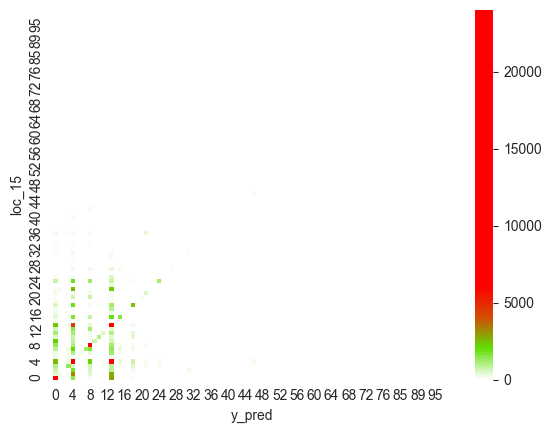

In [35]:
import seaborn as sns

ax = sns.heatmap(matrix,  cmap=custom_ramp)
ax.invert_yaxis()

It can be seen that in case of the cincinnati data, the network does not ONLY learn to predict the last location as the next location.
Nonetheless, a tendency to predict that way in some if not many cases, can also be observed here.
Many predictions also follow more complex patterns.
Thus, this result is more satisfying.

Use the first location to create the matrix and plot the heatmap.

In [40]:
matrix = df.groupby(['y_pred', 'loc_0']).size().unstack(fill_value=0, level=0)
matrix = fill_missing(df, matrix, 'loc_0')
matrix

y_pred,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,93,95,96,97,99
loc_0,,,,,,,,,,,,,,,,,,,,,
0,6968.0,10.0,1.0,99.0,1948.0,0.0,0.0,4.0,279.0,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,514.0,200.0,0.0,194.0,2926.0,0.0,57.0,1.0,401.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,630.0,3.0,54.0,145.0,1892.0,0.0,3.0,50.0,542.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1276.0,5.0,13.0,481.0,850.0,0.0,9.0,137.0,548.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2946.0,46.0,24.0,547.0,20786.0,0.0,41.0,233.0,2557.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


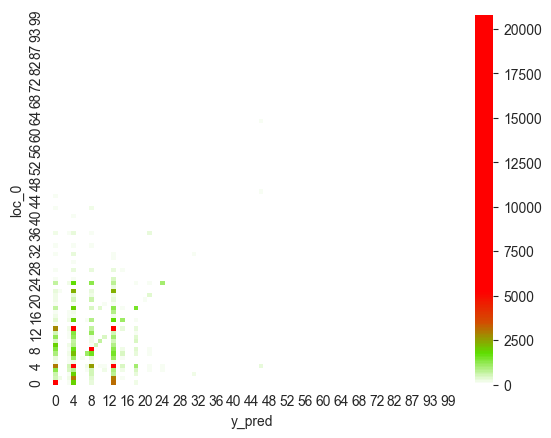

In [41]:
import seaborn as sns

ax = sns.heatmap(matrix,  cmap=custom_ramp)
ax.invert_yaxis()

This proves our statements made above.

Next, the predicted and true values are mapped as a heatmap.

In [42]:
matrix = df.groupby(['y_pred', 'y_true']).size().unstack(fill_value=0, level=0)
matrix = fill_missing(df, matrix, 'y_true')
matrix

y_pred,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,93,94,95,96,97,99
y_true,,,,,,,,,,,,,,,,,,,,,
0,6652.0,5.0,1.0,120.0,2047.0,0.0,0.0,1.0,321.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,576.0,184.0,0.0,162.0,2906.0,0.0,59.0,1.0,397.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,680.0,1.0,60.0,147.0,1870.0,0.0,2.0,34.0,538.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1287.0,18.0,6.0,455.0,919.0,0.0,14.0,142.0,523.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3014.0,42.0,24.0,570.0,20310.0,0.0,51.0,231.0,2487.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


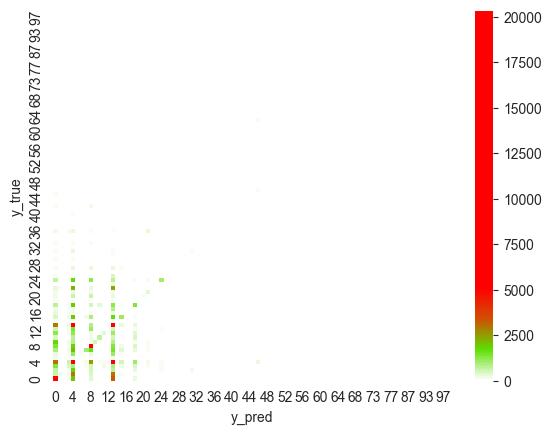

In [43]:
import seaborn as sns

ax = sns.heatmap(matrix,  cmap=custom_ramp)
ax.invert_yaxis()

The evaluation shows that the prediction quality for the cincinnati data is not only performing better but also finds more complex patterns to reach that prediction quality.
As a result, the cincinnati data is to be used for the physical testing.